In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = [0.5, 2.0],
    c2 = [0.5, 2.0],
    w = [0.5, 1.6],
    w_decay = 0.95,
    scale_hyperparameter = False,
    regularizer = l1_regularizer,
    mask = True))

see one see two 2.0 0.5


In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\AI-lab\\github_repo\\neural-network\\', 'dataset')
GROUP = 1
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 200
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 10
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint
    model.optimizer.c1 = np.max([model.optimizer.C1[1] - ((model.optimizer.C1[1] - model.optimizer.C1[0]) * itr / EPOCHS), model.optimizer.C1[0]])
    model.optimizer.c2 = np.min([model.optimizer.C2[0] + ((model.optimizer.C2[1] - model.optimizer.C2[0]) * itr / EPOCHS), model.optimizer.C2[1]])
    model.optimizer.w = np.max([model.optimizer.w * model.optimizer.W_Decay, model.optimizer.W[0]])

Checkpoint 10, Accuracy: 0.8580246913580247, Loss: 0.5434778354786061
Checkpoint 20, Accuracy: 0.8580246913580247, Loss: 0.5417422541865596
Checkpoint 30, Accuracy: 0.8888888888888888, Loss: 0.48916004322193285
Checkpoint 40, Accuracy: 0.9382716049382716, Loss: 0.4400327823780201
Checkpoint 50, Accuracy: 0.9259259259259259, Loss: 0.37488806689227067
Checkpoint 60, Accuracy: 0.9444444444444444, Loss: 0.31278500733552156
Checkpoint 70, Accuracy: 0.9691358024691358, Loss: 0.305678579542372
Checkpoint 80, Accuracy: 0.9629629629629629, Loss: 0.26660883868182145
Checkpoint 90, Accuracy: 0.9691358024691358, Loss: 0.2447109752231174
Checkpoint 100, Accuracy: 0.9691358024691358, Loss: 0.2370981287073206
Checkpoint 110, Accuracy: 0.9753086419753086, Loss: 0.2405294312371148
Checkpoint 120, Accuracy: 0.9691358024691358, Loss: 0.22187342467131438
Checkpoint 130, Accuracy: 0.9691358024691358, Loss: 0.18328173955281576
Checkpoint 140, Accuracy: 0.9691358024691358, Loss: 0.18328173955281576
Checkpoin

In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
train_acc = [h['accuracy'] for h in history]
train_mse = [h['mean_square_error'] for h in history]
train_cce = [h['categorical_crossentropy'] for h in history]

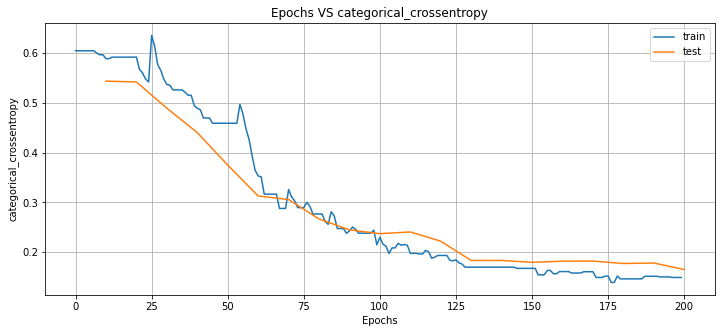

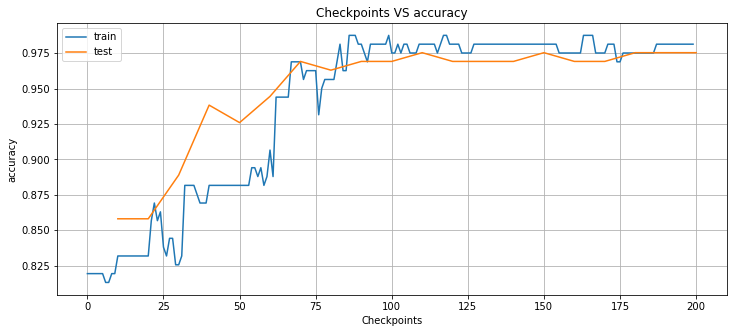

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_cce, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_acc, acc], x_label = 'Checkpoints', \
    y_label = 'accuracy', legend=['train', 'test'])

In [12]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.9304074  0.02800482 0.04158782]
[1. 0. 0.] <-> [0.9331578  0.02311949 0.04372272]
[1. 0. 0.] <-> [0.87994206 0.03428026 0.08577777]
[1. 0. 0.] <-> [0.94853896 0.0272928  0.02416827]
[1. 0. 0.] <-> [0.8166803  0.04278332 0.1405363 ]
[1. 0. 0.] <-> [0.9202145  0.05460202 0.02518348]
[1. 0. 0.] <-> [0.94663864 0.04017922 0.01318213]
[1. 0. 0.] <-> [0.772128   0.03251803 0.19535393]
[1. 0. 0.] <-> [0.8503366  0.02655621 0.12310717]
[1. 0. 0.] <-> [0.91710186 0.03244551 0.05045253]
[1. 0. 0.] <-> [0.94247466 0.03567461 0.02185075]
[0. 1. 0.] <-> [0.07544047 0.92184794 0.00271165]
[1. 0. 0.] <-> [0.93492186 0.03279466 0.03228341]
[1. 0. 0.] <-> [0.9202565  0.02691107 0.05283244]
[1. 0. 0.] <-> [0.9532155  0.02565648 0.02112811]
[1. 0. 0.] <-> [0.9240206  0.06395914 0.01202027]
[1. 0. 0.] <-> [0.8339974  0.03460222 0.13140038]
[1. 0. 0.] <-> [0.9439477  0.04187673 0.01417566]
[1. 0. 0.] <-> [0.8913954  0.09204496 0.01655961]
[1. 0. 0.] <-> [0.9592307  0.02326786 0.01750141]


In [13]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8580246913580247, 'mean_square_error': 0.3287542830317377, 'categorical_crossentropy': 0.5434778354786061, 'essential_metrics': {0: {'tp_hit': 71, 'fp_hit': 14, 'tn_hit': 14, 'fn_hit': 9}, 1: {'tp_hit': 4, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 11}, 2: {'tp_hit': 10, 'fp_hit': 9, 'tn_hit': 86, 'fn_hit': 3}}, 'checkpoint': 10} 


{'accuracy': 0.8580246913580247, 'mean_square_error': 0.31615348984269903, 'categorical_crossentropy': 0.5417422541865596, 'essential_metrics': {0: {'tp_hit': 70, 'fp_hit': 13, 'tn_hit': 15, 'fn_hit': 10}, 1: {'tp_hit': 5, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 10}, 2: {'tp_hit': 10, 'fp_hit': 10, 'tn_hit': 85, 'fn_hit': 3}}, 'checkpoint': 20} 


{'accuracy': 0.8888888888888888, 'mean_square_error': 0.2571895882778329, 'categorical_crossentropy': 0.48916004322193285, 'essential_metrics': {0: {'tp_hit': 79, 'fp_hit': 17, 'tn_hit': 11, 'fn_hit': 1}, 1: {'tp_hit': 1, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 14}, 2: {'tp_hit': 10, 'fp_hit': 1, 'tn_hit': 94, 

In [14]:
print(model)

Layer 1
Neuron 0: weights:
[ 1.2269329  -0.11089011 -0.03928297 -0.05149681 -0.12418082]
 bias: 0.16218151152133942

Neuron 1: weights:
[ 0.00658882  1.4241251   0.08777791 -0.7248056  -1.6343852 ]
 bias: 1.1545274257659912

Neuron 2: weights:
[ 0.11238723 -0.98235303 -0.05101048  0.01715311  1.2459214 ]
 bias: -0.14943839609622955

Neuron 3: weights:
[-1.131312    3.          1.4189115  -0.1164602  -0.42504084]
 bias: -1.85213041305542

$
Layer 2
Neuron 0: weights:
[ 0.1081539   3.          0.04483254 -2.7614021 ]
 bias: 0.044555842876434326

Neuron 1: weights:
[-0.94881105 -0.02132111 -1.6470376   3.        ]
 bias: 0.03755343332886696

Neuron 2: weights:
[ 0.05638621 -2.8653026   2.6078103  -0.23708877]
 bias: -0.08759547770023346

$

